# Rede VGG19 com pesos ImageNet

Este notebook carrega a rede VGG19 com os pesos treinados da rede vencedora da ImageNet.

- A rede VGG19 é criada e carregada com os pesos da ImageNet
- Uma imagem é preparada para fazer a predição
- A predição de uma imagem
- Mostra a classe da imagem de acordo com a classificação da ImageNet

A rede VGG19 é uma rede sequencial.

Os detalhes de criação da rede podem ser vistos em:

- [VGG19 no Pytorch](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py)

<img src="../figures/VGG19.png", width= 500pt></img>

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.autograd import Variable
import torchvision.transforms as transforms

import torchvision
from PIL import Image
import json

In [104]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: True


In [105]:
CLASS_INDEX = None
CLASS_INDEX_PATH = '/data/datasets/imagenet_class_index.json'
def decode_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        with open(CLASS_INDEX_PATH, 'r') as file:
            CLASS_INDEX = json.load(file)
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results

def preprocess_input(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}

    if dim_ordering == 'th':
        x[:, 0, :, :] -= 103.939
        x[:, 1, :, :] -= 116.779
        x[:, 2, :, :] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        x[:, :, :, 0] -= 103.939
        x[:, :, :, 1] -= 116.779
        x[:, :, :, 2] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x


In [280]:
MODEL = {
    'alexnet':     torchvision.models.alexnet,
    'vgg11':       torchvision.models.vgg11,
    'vgg19':       torchvision.models.vgg19,
    'vgg11bn':     torchvision.models.vgg11_bn,
    'vgg19bn':     torchvision.models.vgg19_bn,
    'resnet18':    torchvision.models.resnet18,
    'resnet152':   torchvision.models.resnet152,
    'squeezenet':  torchvision.models.squeezenet1_1,
    
}

#model = torchvision.models.vgg19(pretrained=True)
model = MODEL['squeezenet'](pretrained=True)

print(model)

SqueezeNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Fire (
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU (inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU (inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU (inplace)
    )
    (4): Fire (
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU (inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU (inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU (inplace)
    )
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1,

In [292]:
img_path = '/data/datasets/images/malamute.jpeg'
#img_path = '/data/datasets/images/egyptian cat.jpeg'
#img_path = '/data/datasets/images/hay.jpg'
#img_path = '/data/datasets/images/tank.jpg'

img = Image.open(img_path)

(360, 480, 3)

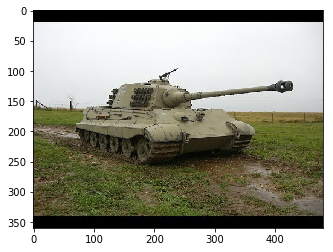

In [293]:
# Convertendo para NumPy Array e mostrando com matplotlib
x = np.array(img)
plt.imshow(x)
x.shape

In [283]:
format_image = transforms.Compose([
    transforms.Scale((300,300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

inputs = format_image(img)

inputs = Variable(inputs.unsqueeze(0))
print(inputs.size())

torch.Size([1, 3, 300, 300])


In [284]:
output = torch.nn.functional.softmax(model(inputs))
print('Predicted:')
for i, sample in enumerate(decode_predictions(output.data.numpy())):
    print('\nImagem ', i)
    for rank, prediction in enumerate(sample):
        print('{}: {:20} - score: {:2.3f}'.format(rank+1, prediction[1], prediction[2]))

Predicted:

Imagem  0
1: Norwegian_elkhound   - score: 0.675
2: malamute             - score: 0.181
3: Eskimo_dog           - score: 0.077
4: Siberian_husky       - score: 0.055
5: German_shepherd      - score: 0.004
